In [ ]:
MODEL_ORDER = ["Claude Code", "OpenAI Codex CLI: o4-mini", "OpenAI Codex CLI: o3-high", "C-Agent: o3-high", "C-Agent: GPT-4.1", "C-Agent: Gemini 2.5", "C-Agent: Claude 3.7"]

In [ ]:
# Run as setup cell

!pip install --upgrade gspread gspread_dataframe --quiet

# Mount drive to colab (may need to give permission)
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 1.8 MB/s eta 0:00:00
Mounted at /content/drive


# Update google sheet


In [ ]:
def open_up_google_sheet():
  import gspread
  from google.colab import auth
  from google.auth.transport.requests import Request
  from google.auth import default

  auth.authenticate_user()
  creds, _ = default()
  gc = gspread.authorize(creds)

  sh = gc.open_by_key("1h7PhY7T00eix-CVTgWBidGuTxCpmxSsF4yZZgGalq1w")
  return sh

In [ ]:
import gspread
from gspread_dataframe import set_with_dataframe

def write_tables_to_google_sheet(sheet, tables_dict):
    for tab_name, df in tables_dict.items():
        try:
            worksheet = sheet.worksheet(tab_name)
            worksheet.clear()
        except gspread.WorksheetNotFound:
            worksheet = sheet.add_worksheet(title=tab_name, rows=1000, cols=26)

        set_with_dataframe(worksheet, df)
        print(f"✅ Wrote '{tab_name}' to sheet.")

In [ ]:
import os
import json
import pandas as pd
import re
from datetime import datetime
from typing import List, Callable, Dict

def get_data():
  exploit_dirs = [
      "Runs - o3 - 1/exploit",
      "Runs - o3 - 1/detect",
      "Runs - o3 - 1/detect_cwe-title",
      "Runs - o3 - 1/detect_cwe-only",
      "pass_at_1_flat_json/exploit",
      "pass_at_1_flat_json/detect",
      "pass_at_1_flat_json/detect_cwe-title",
      "pass_at_1_flat_json/detect_cwe-only",
      ]

  patch_dirs = [
      "Runs - o3 - 1/patch",
      "pass_at_1_flat_json/patch",
      ]

  all_data_df = pd.DataFrame()

  def get_workflow_type(dir):
    if "title" in dir:
      return "CWE + Title"
    if "cwe" in dir:
      return "CWE"
    if "detect" in dir:
      return "No Info"
    else:
      return "Report"

  for exploit_dir in exploit_dirs:
      all_paths = get_all_log_file_paths([exploit_dir])
      # all_paths = [p for p in all_paths if "/o3 - 2/" not in p and "/codex - 2/" not in p]
      dir_df = load_in_log_data(all_paths)
      dir_df["workflow"] = "Exploit"
      dir_df["workflow_type"] = get_workflow_type(exploit_dir)
      all_data_df = pd.concat([all_data_df, dir_df], ignore_index=True)

  for patch_dir in patch_dirs:
      all_paths = get_all_log_file_paths([patch_dir])
      # all_paths = [p for p in all_paths if "/o3 - 2/" not in p and "/codex - 2/" not in p]
      dir_df = load_in_log_data(all_paths)
      dir_df["workflow"] = "Patch"
      dir_df["workflow_type"] = get_workflow_type(patch_dir)
      all_data_df = pd.concat([all_data_df, dir_df], ignore_index=True)

  return all_data_df

In [ ]:
sh = open_up_google_sheet()

In [ ]:
data = get_data()

In [ ]:
mask = data['filepath'].str.contains('codex', case=False, na=False)
data.loc[mask, ['model_name', 'agent_scaffold']] = 'OpenAI Codex CLI: o4-mini'

mask = data['filepath'].str.contains('codex', case=False, na=False) & data['filepath'].str.contains('openai-o3', case=False, na=False)
data.loc[mask, ['model_name', 'agent_scaffold']] = 'OpenAI Codex CLI: o3-high'


mask = data['filepath'].str.contains('claude-code', case=False, na=False)
data.loc[mask, ['model_name', 'agent_scaffold']] = 'Claude Code'

completed_data_df = data[data['complete'] == "True"].reset_index(drop=True)
completed_data_df = data[data['workflow_name'] != "DetectPatchWorkflow"].reset_index(drop=True)


completed_data_df = completed_data_df.drop(columns=['complete', 'helm_run', 'task_dir', 'bounty_number'], errors='ignore')
completed_data_df['success'] = completed_data_df['success'].astype(str).str.strip().str.lower().map({'true': 1, 'false': 0})
completed_data_df['invariant_pass'] = completed_data_df['invariant_pass'].astype(str).str.strip().str.lower().map({'true': 1, 'false': 0})
completed_data_df['exploit_pass'] = completed_data_df['exploit_pass'].astype(str).str.strip().str.lower().map({'true': 1, 'false': 0})

import ast
import pandas as pd

def check_row_consistency(row_val):
    if pd.isna(row_val):
        return True  # Treat NaN as consistent
    try:
        scores = ast.literal_eval(row_val) if isinstance(row_val, str) else row_val
        if not scores:
            return True
        return all(score == scores[0] for score in scores)
    except (ValueError, SyntaxError, TypeError):
        return True  # If unparsable, treat as consistent

completed_data_df["cia_consistent"] = completed_data_df["cia_scores"].apply(check_row_consistency)

models = {
    "anthropic/claude-3-7-sonnet-20250219-extended-thinking": "C-Agent: Claude 3.7",
    "openai/gpt-4.1-2025-04-14": "C-Agent: GPT-4.1",
    "google/gemini-2.5-pro-preview-03-25": "C-Agent: Gemini 2.5",
    "openai/o3-2025-04-16-high-reasoning-effort": "C-Agent: o3-high",
    "Claude Code": "Claude Code",
    "OpenAI Codex CLI: o3-high": "OpenAI Codex CLI: o3-high",
    "OpenAI Codex CLI: o4-mini": "OpenAI Codex CLI: o4-mini",
}

completed_data_df["model_name"] = completed_data_df["model_name"].map(models)

# Desired column order
first_cols = [
    'workflow_name',
    'workflow',
    'workflow_type',
    'task_name',
    'filelink',
    'success',
    'phase_summary',
    'model_name',
]

last_cols = ['invariant_pass',
             'exploit_pass',
             'workflow_id',
             'total_input_tokens',
             'total_output_tokens',
             'total_query_time_taken_in_s',
             'total_iteration_time_s',
             'model_max_input_tokens',
             'model_max_output_tokens', ]

# All remaining columns that aren't in first or last
middle_cols = [col for col in completed_data_df.columns if col not in first_cols + last_cols]

# Reorder the DataFrame
completed_data_df = completed_data_df[first_cols + middle_cols + last_cols]

completed_data_df['agent_scaffold'] = completed_data_df['agent_scaffold'].astype(str).str.strip()
completed_data_df['model_name'] = completed_data_df['model_name'].astype(str).str.strip()

# Apply the update
completed_data_df.loc[completed_data_df['workflow_name'] == "DetectWorkflow", 'workflow_name'] = "Detect"
completed_data_df.loc[completed_data_df['workflow_name'] == "ExploitWorkflow", 'workflow_name'] = "Exploit"
completed_data_df.loc[completed_data_df['workflow_name'] == "PatchWorkflow", 'workflow_name'] = "Patch"

completed_data_df.rename(columns={"model_name": "Agent"}, inplace=True)

completed_data_df.loc[
    (completed_data_df['workflow_type'] == 'CWE + Title') &
    (completed_data_df['task_name'] == 'pytorch-lightning_0') &
    (completed_data_df['Agent'] == 'Claude Code'),
    'success'
] = 1
completed_data_df.loc[
    (completed_data_df['workflow_type'] == 'CWE') &
    (completed_data_df['task_name'] == 'pytorch-lightning_0') &
    (completed_data_df['Agent'] == 'C-Agent: Claude 3.7'),
    'success'
] = 1

In [ ]:
# completed_data_df = pd.read_csv('/content/Pass@K Runs - Copy of Totals (1).csv')
print(len(completed_data_df))
# import pandas as pd

1412


In [ ]:
write_tables_to_google_sheet(sh, {"Pass@1 Totals": completed_data_df})

✅ Wrote 'Pass@1 Totals' to sheet.


# Cost

In [ ]:
# # Get the filtered dataframe first
# gemini_df = completed_data_df[completed_data_df['Agent'] == "C-Agent: Gemini 2.5"]

# # Loop through each unique workflow_name
# for workflow_name in gemini_df['workflow_name'].unique():
#     # Get subset for this workflow_name
#     workflow_df = gemini_df[gemini_df['workflow_name'] == workflow_name]

#     print(f"\nWorkflow Name: {workflow_name}")
#     print("-" * 40)

#     # Now loop through each workflow_type within this workflow_name
#     for workflow_type in workflow_df['workflow_type'].unique():
#         # Get subset for this workflow_type
#         type_df = workflow_df[workflow_df['workflow_type'] == workflow_type]

#         # Calculate sums
#         input_sum = type_df['total_input_tokens'].astype(int).sum() * (1.25 / 1000000)
#         output_sum = type_df['total_output_tokens'].astype(int).sum() * (10 / 1000000)

#         # Print results
#         print(f"Workflow Type: {workflow_type}")
#         print(f"  Total Input cost: {input_sum}")
#         print(f"  Total Output cost: {output_sum}")
#         print(f" Total: {round(input_sum + output_sum, 2)}")
#         print("-" * 30)

In [ ]:
# Get the filtered dataframe first
gemini_df = completed_data_df[completed_data_df['Agent'] == "C-Agent: Claude 3.7"]

# Loop through each unique workflow_name
for workflow_name in gemini_df['workflow_name'].unique():
    # Get subset for this workflow_name
    workflow_df = gemini_df[gemini_df['workflow_name'] == workflow_name]

    print(f"\nWorkflow Name: {workflow_name}")
    print("-" * 40)

    # Now loop through each workflow_type within this workflow_name
    for workflow_type in workflow_df['workflow_type'].unique():
        # Get subset for this workflow_type
        type_df = workflow_df[workflow_df['workflow_type'] == workflow_type]

        # Calculate sums
        input_sum = type_df['total_input_tokens'].astype(int).sum() * (3 / 1000000)
        output_sum = type_df['total_output_tokens'].astype(int).sum() * (15 / 1000000)

        # Print results
        print(f"Workflow Type: {workflow_type}")
        print(f"  Total Input cost: {input_sum}")
        print(f"  Total Output cost: {output_sum}")
        print(f" Total: {round(input_sum + output_sum, 2)}")
        print("-" * 30)


Workflow Name: Exploit
----------------------------------------
Workflow Type: Report
  Total Input cost: 14.529564
  Total Output cost: 15.2415
 Total: 29.77
------------------------------

Workflow Name: Detect
----------------------------------------
Workflow Type: No Info
  Total Input cost: 31.335003
  Total Output cost: 38.09514
 Total: 69.43
------------------------------
Workflow Type: CWE + Title
  Total Input cost: 28.118925
  Total Output cost: 34.448370000000004
 Total: 62.57
------------------------------
Workflow Type: CWE
  Total Input cost: 26.755476
  Total Output cost: 32.86863
 Total: 59.62
------------------------------

Workflow Name: Patch
----------------------------------------
Workflow Type: Report
  Total Input cost: 13.67115
  Total Output cost: 14.673465
 Total: 28.34
------------------------------


In [ ]:
# Get the filtered dataframe first
gemini_df = completed_data_df[completed_data_df['Agent'] == "C-Agent: GPT-4.1"]

# Loop through each unique workflow_name
for workflow_name in gemini_df['workflow_name'].unique():
    # Get subset for this workflow_name
    workflow_df = gemini_df[gemini_df['workflow_name'] == workflow_name]

    print(f"\nWorkflow Name: {workflow_name}")
    print("-" * 40)

    # Now loop through each workflow_type within this workflow_name
    for workflow_type in workflow_df['workflow_type'].unique():
        # Get subset for this workflow_type
        type_df = workflow_df[workflow_df['workflow_type'] == workflow_type]

        # Calculate sums
        input_sum = type_df['total_input_tokens'].astype(int).sum() * (2 / 1000000)
        output_sum = type_df['total_output_tokens'].astype(int).sum() * (8 / 1000000)

        # Print results
        print(f"Workflow Type: {workflow_type}")
        print(f"  Total Input cost: {input_sum}")
        print(f"  Total Output cost: {output_sum}")
        print(f" Total: {round(input_sum + output_sum, 2)}")
        print("-" * 30)


Workflow Name: Exploit
----------------------------------------
Workflow Type: Report
  Total Input cost: 2.365904
  Total Output cost: 1.2758
 Total: 3.64
------------------------------

Workflow Name: Detect
----------------------------------------
Workflow Type: No Info
  Total Input cost: 9.698224
  Total Output cost: 5.552664
 Total: 15.25
------------------------------
Workflow Type: CWE + Title
  Total Input cost: 7.80779
  Total Output cost: 4.76444
 Total: 12.57
------------------------------
Workflow Type: CWE
  Total Input cost: 9.677406
  Total Output cost: 6.0619119999999995
 Total: 15.74
------------------------------

Workflow Name: Patch
----------------------------------------
Workflow Type: Report
  Total Input cost: 8.902334
  Total Output cost: 5.4342239999999995
 Total: 14.34
------------------------------


# Data


In [ ]:
print(len(completed_data_df))

1412


In [ ]:
def create_task_and_mega_tables(df):
    import pandas as pd
    import re

    # Clean up task metadata table
    task_table = df[["task_name", "severity", "disclosure_bounty", "patch_bounty"]].drop_duplicates()
    task_table = task_table.drop_duplicates(subset='task_name', keep='first')
    task_table = task_table.dropna(subset=["task_name"]).reset_index(drop=True)
    task_table = task_table.sort_values(by='task_name').reset_index(drop=True)

    def normalize_severity(severity_col):
        def extract_number(val):
            if pd.isna(val):
                return None
            if isinstance(val, (int, float)):
                return float(val)
            match = re.search(r"(\d+(\.\d+)?)", str(val))
            return float(match.group(1)) if match else None
        return severity_col.apply(extract_number)

    task_table["severity"] = normalize_severity(task_table["severity"])

    # Sort to prioritize successful runs and maintain original order otherwise
    df_sorted = df.sort_values(by=["success"], ascending=[False])

    # Group and take the most successful or first run per (Agent, workflow_name, workflow, workflow_type, task_name)
    df_grouped = (
        df.groupby(["Agent", "workflow_name", "workflow", "workflow_type", "task_name"])
          .apply(lambda g: g[g["success"] == True].iloc[0] if any(g["success"]) else g.iloc[0])
          .reset_index(drop=True)
    )


    def extract_task_metrics(row):
        detected_bounties = row.get("These are the detected bounties")
        if pd.isna(detected_bounties) or detected_bounties == 'nan':
            detected_bounties = row.get("detected_bounties")
        return {
            "success": bool(row.get("success", False)),
            "phase_summary": row.get("phase_summary", None),
            "filelink": row.get("filelink", None),
            "total_input_tokens": row.get("total_input_tokens", None),
            "total_output_tokens": row.get("total_output_tokens", None),
            "total_query_time_taken_in_s": row.get("total_query_time_taken_in_s", None),
            "total_iteration_time_s": row.get("total_iteration_time_s", None),
            "detected bounties": detected_bounties,
            "invariant_pass": row.get("invariant_pass", None),
            "exploit_pass": row.get("exploit_pass", None),
            "invariant_scores": row.get("invariant_scores", None),
            "bounty_invariant_scores": row.get("bounty_invariant_scores", None),
            "invariant_threshold": row.get("invariant_threshold", None)
        }

    mega_records = {}
    for _, row in df_grouped.iterrows():
        key = (
            row["Agent"],
            row["workflow_name"],
            row["workflow"],
            row["workflow_type"]
        )

        if key not in mega_records:
            mega_records[key] = {
                "Agent": key[0],
                "workflow_name": key[1],
                "workflow": key[2],
                "workflow_type": key[3],
            }

        task = row["task_name"]
        if pd.notna(task):
            mega_records[key][task] = extract_task_metrics(row)

    mega_table = pd.DataFrame.from_dict(mega_records, orient="index").reset_index(drop=True)

    return task_table, mega_table

task_table, megatable = create_task_and_mega_tables(completed_data_df)
# task_table = task_table.iloc[:-2]

<ipython-input-391-ee55fd3cab5b>:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[g["success"] == True].iloc[0] if any(g["success"]) else g.iloc[0])


In [ ]:
import pandas as pd

def split_patch_exploit_dfs(df: pd.DataFrame) -> dict[str, pd.DataFrame]:
    """
    Returns a dict mapping each Agent to a DataFrame of its
    Patch–workflow runs that:
      • succeeded (success==True)
      • appeared exactly 3 times for that task
      • passed exploit (exploit_pass==True)
    """
    # 1) only Patch
    df_patch = df[df['workflow'] == 'Patch'].copy()
    # 2) drop runs that didn't complete
    df_patch = df_patch[df_patch['success'] == False]
    print(len(df_patch))

    # 3) for each (Agent, task_name) count how many runs; keep only those == 3
    run_counts = (
        df_patch
        .groupby(['Agent', 'task_name'])
        .size()
        .reset_index(name='n_runs')
    )
    valid = run_counts[run_counts['n_runs'] == 3][['Agent','task_name']]

    df_valid = df_patch.merge(valid, on=['Agent','task_name'], how='inner')

    # 4) only exploit_pass == True
    df_valid = df_valid[df_valid['exploit_pass'] == True]
    cols = [
        'workflow_name',
        'workflow',
        'workflow_type',
        'task_name',
        'Agent',
        'invariant_scores',
        'bounty_invariant_scores',
        'invariant_threshold',
        'invariant_pass',
        'exploit_pass'
    ]
    df_valid = df_valid[cols]

    df_valid = df_valid.sort_values(['Agent', 'task_name'])
    # 5) split into one df per Agent
    # agent_dfs = {
    #     agent: subdf.reset_index(drop=True)
    #     for agent, subdf in df_valid.groupby('Agent')
    # }
    return df_valid

# Usage:
agent_dfs = split_patch_exploit_dfs(completed_data_df)
write_tables_to_google_sheet(sh, {"Patch Invariants": agent_dfs})

# # Now you have a dict of 5 DataFrames, e.g.
# for agent, df_agent in agent_dfs.items():
#     print(f"\nAgent: {agent}, {len(df_agent)} rows")
#     display(df_agent)


143
✅ Wrote 'Patch Invariants' to sheet.


In [ ]:
import pandas as pd

task_table = pd.read_csv('/content/descriptions on repos_bounties - Copy of Bounty Table.csv')
# display(task_table)
task_table['task_name'] = (
    task_table['Repo Name'].astype(str)
    + '_'
    + task_table['Bounty Number'].astype(str)
)

# 2. Rename the award columns
task_table = task_table.rename(
    columns={
        'Detect Award': 'disclosure_bounty',
        'Patch Award': 'patch_bounty'
    }
)

# 3. Select only the desired columns
task_table = task_table[['task_name', 'disclosure_bounty', 'patch_bounty']]

# print(task_table)

In [ ]:
# display(megatable)
write_tables_to_google_sheet(sh, {"Megatable": megatable})
# write_tables_to_google_sheet(sh, {"Totals": completed_data_df})

✅ Wrote 'Megatable' to sheet.


# Get missing logs

In [ ]:
def find_missing_logs(mega_table, task_columns=None):
    missing_logs = []

    if task_columns is None:
        # Auto-detect task columns: those with dict-like values
        task_columns = [col for col in mega_table.columns if col not in ["Agent", "workflow_name", "workflow", "workflow_type"]]

    for _, row in mega_table.iterrows():
        for task in task_columns:
            cell = row.get(task)
            if isinstance(cell, dict):
                if not cell.get("filelink"):
                    model = row["Agent"]
                    # if pd.isna(model):
                    #   model = "Claude code"
                    missing_logs.append({
                        "Agent": model,
                        "workflow_name": row["workflow_name"],
                        "workflow": row["workflow"],
                        "workflow_type": row["workflow_type"],
                        "task": task
                    })
            elif pd.isna(cell) or cell is None:
                model = row["Agent"]
                # if pd.isna(model):
                #   model = "Claude Code"
                # No entry for this task at all
                missing_logs.append({
                    "Agent": model,
                    "workflow_name": row["workflow_name"],
                    "workflow": row["workflow"],
                    "workflow_type": row["workflow_type"],
                    "task": task
                })

    return pd.DataFrame(missing_logs)

missing_logs_df = find_missing_logs(megatable)

In [ ]:
# display(missing_logs_df)
write_tables_to_google_sheet(sh, {"Missing logs": missing_logs_df})

✅ Wrote 'Missing logs' to sheet.


# Get metrics


In [ ]:
import ast
import re

def generate_success_table(mega_table, task_table):
    task_names = [t for t in task_table["task_name"].unique()]
    success_table_records = []

    for _, row in mega_table.iterrows():
        record = {
            "Agent": row["Agent"],
            "workflow_name": row["workflow_name"],
            "workflow": row["workflow"],
            "workflow_type": row["workflow_type"]
        }

        # if row["workflow_type"] != "Report":
          # Step 1: Detect success set for detect workflows
        # detect_success_set = set()
        # for task in task_names:
        #     cell = row.get(task)
        #     if not isinstance(cell, dict):
        #         continue
        #     detected = cell.get("detected bounties")
        #     if not detected:
        #         continue
        #     base_name = re.sub(r"_\d+$", "", task)
        #     parts = []

        #     if isinstance(detected, list):
        #         # Join all parts to a single string if it's already a list
        #         detected_str = ",".join(map(str, detected))
        #     else:
        #         detected_str = str(detected)

        #     for part in detected_str.split(","):
        #         part = re.sub(r"\D", "", part)  # remove non-digits
        #         if part.isdigit():
        #             detected_task = f"{base_name}_{int(part)}"
        #             detect_success_set.add(detected_task)

        # Step 2: Compute task success values
        for task in task_names:
            cell = row.get(task)
            if isinstance(cell, dict):
                # detected = cell.get("detected bounties")
                # if not detected:
                record[task] = cell.get("success")
                    # continue

                # base_name = re.sub(r"_\d+$", "", task)
                # parts = []

                # if isinstance(detected, list):
                #     # Join all parts to a single string if it's already a list
                #     detected_str = ",".join(map(str, detected))
                # else:
                #     detected_str = str(detected)

                # if "nan" in detected_str:
                #   record[task] = cell.get("success")
                #   continue
                #   record[task] = task in detect_success_set
          # else:
          #   record[task] = cell.get("success")

        success_table_records.append(record)

    success_df = pd.DataFrame(success_table_records)
    return success_df

success_df = generate_success_table(megatable, task_table)
write_tables_to_google_sheet(sh, {"Successes @1": success_df})

✅ Wrote 'Successes @1' to sheet.


In [ ]:
import pandas as pd
import ast
import re

def check_row_consistency(row):
    first = row[0]
    for i, d in enumerate(row[1:], start=1):
        if d != first:
          print(f"Warning, mismatch in row: {row}")
    return True

def generate_patch_table(mega_table, task_table):
    task_names = task_table["task_name"].unique()
    records = []

    for _, row in mega_table.iterrows():
        model_name = row.get("Agent", "UNKNOWN")

        for task in task_names:
            cell = row.get(task)

            # Start the row with model and task
            result = {
                "Agent": model_name,
                "filelink": None,
                "task": task,
                "workflow_name": row.get("workflow_name"),
                "workflow_type": row.get("workflow_type"),
                "exploit_pass": None,
                "invariant_pass": None,
                "invariant_comparisons": None,
            }

            if isinstance(cell, dict):
                result["exploit_pass"] = int(cell.get("exploit_pass", 0))
                if result["exploit_pass"]:
                  result["invariant_pass"] = int(cell.get("invariant_pass", 0))
                  result["filelink"] = cell.get("filelink")

                  # Invariant comparison (e.g., ["1/1", "0/1"])
                  scores = cell.get("invariant_scores")
                  b_scores = cell.get("bounty_invariant_scores")
                  thresholds = cell.get("invariant_threshold")
                  if thresholds:
                      thresholds = ast.literal_eval(thresholds)
                      scores = ast.literal_eval(scores)
                      b_scores = ast.literal_eval(b_scores)
                      if scores:
                        check_row_consistency(scores)
                        check_row_consistency(b_scores)
                      comparisons = []
                      for key, value in thresholds.items():
                          score = scores[-1].get(key) if scores else None
                          b_score = b_scores[-1].get(key) if scores else None
                          if score is not None:
                              comparisons.append(f"{score}/{value}")
                          elif b_score is not None:
                              comparisons.append(f"{b_score}/{value}")
                          else:
                              comparisons.append(f"--/{value}")
                      result["invariant_comparisons"] = comparisons

                  records.append(result)

    success_df = pd.DataFrame(records)
    return success_df

patch_mega = megatable[megatable["workflow"] == "Patch"]
patch_mega = patch_mega[patch_mega["Agent"].notna()].reset_index(drop=True)
patch_df = generate_patch_table(patch_mega, task_table)

Warning, mismatch in row: [{'unit_tests': 435}, {}, {'unit_tests': 435}]


In [ ]:
def escape_latex(s):
    s = str(s)
    s = s.replace("_", " ")
    return (
        s.replace("&", "\\&")
         .replace("%", "\\%")
         .replace("$", "\\$")
         .replace("#", "\\#")
         .replace("{", "\\{")
         .replace("}", "\\}")
         .replace("~", "\\textasciitilde{}")
         .replace("^", "\\textasciicircum{}")
    )

workflow_order = ["Report"]

def format_comparisons(comparisons, passed):
    if not comparisons:
        return ""
    comps = [escape_latex(c) for c in comparisons]
    joined = ", ".join(comps)
    if passed:
        return rf"\textcolor{{c_green}}{{{joined}}}"
    return joined

def generate_patch_latex_tables(df, model_order):
    df = df.copy()
    latex_blocks = []

    for model_name in model_order:
        if model_name not in df["Agent"].unique():
            continue

        model_df = df[df["Agent"] == model_name]
        for workflow_type in workflow_order:
            if workflow_type not in model_df["workflow_type"].unique():
                continue  # skip missing types

            group = model_df[model_df["workflow_type"] == workflow_type].sort_values("task")

            # Compute totals
            total_exploit_pass = group["exploit_pass"].sum()
            total_invariant_pass = group["invariant_pass"].sum()

            block = [
                r"\begin{table}[htbp]",
                r"\centering",
                rf"\caption{{Patch results for \textbf{{{escape_latex(model_name)}}} where the exploit was successfully mitigated. For each task, we report whether the invariants passed and show score comparisons. -- indicates no score was outputted by the corresponding test suite.}}",
                rf"\label{{tab:patch_{model_name.lower().replace(' ', '_')}}}",
                r"\begin{tabular}{lccl}",
                r"\toprule",
                r"\textbf{Task} & \textbf{Exploit} & \textbf{Invariant} & \textbf{Invariant Comparisons} \\",
                r"\midrule",
                rf"\textbf{{Total}} & \textbf{{{total_exploit_pass}}} & \textbf{{{total_invariant_pass}}} & \\",
                r"\midrule"
            ]

            for _, row in group.iterrows():
                task = escape_latex(row["task"])
                exploit = r"\textcolor{c_green}{\checkmark}" if row["exploit_pass"] else r"\textcolor{c_red}{X}"
                invariant = r"\textcolor{c_green}{\checkmark}" if row["invariant_pass"] else r"\textcolor{c_red}{X}"
                comps = format_comparisons(row["invariant_comparisons"], row["invariant_pass"])
                block.append(f"{task} & {exploit} & {invariant} & {comps} \\\\")

            block.extend([
                r"\bottomrule",
                r"\end{tabular}",
                r"\end{table}",
                ""  # spacer
            ])

            latex_blocks.append("\n".join(block))

    return "\n\n".join(latex_blocks)


# Usage (assuming `patch_df` and `MODEL_ORDER` are defined):
latex_code = generate_patch_latex_tables(patch_df, MODEL_ORDER)

# Optionally write to file:
with open("patch_summary.tex", "w") as f:
    f.write(latex_code)


In [ ]:
def sort_models(models):
    order = MODEL_ORDER
    return sorted(models, key=lambda x: order.index(x) if x in order else len(order))

def sort_info_levels(levels):
    order = ["No Info", "CWE", "CWE + Title", "Report"]
    return sorted(levels, key=lambda x: order.index(x) if x in order else len(order))

def compute_task_success_subtable(success_df, group_col):
    task_names = sorted([col for col in success_df.columns if col not in {"Agent", "workflow", "workflow_name", "workflow_type"}])
    group_values = sorted(success_df[group_col].dropna().unique())

    if group_col == "Agent":
        group_values = sort_models(group_values)
    elif group_col == "workflow_type":
        group_values = sort_info_levels(group_values)

    results = []
    for task in task_names:
        row = {"task_name": task}
        grouped = success_df.groupby(group_col)[task].agg(["sum", "count"])
        for grp in group_values:
            total = grouped.loc[grp, "count"] if grp in grouped.index else 0
            successes = grouped.loc[grp, "sum"] if grp in grouped.index else 0
            row[grp] = successes / total if total > 0 else None
        results.append(row)

    df = pd.DataFrame(results)

    # Add sum and percent rows
    sum_row = {"task_name": "SUM"}
    pct_row = {"task_name": "%"}
    for col in group_values:
        vals = df[col].dropna()
        total = len(vals)
        total_successes = (vals * 1).sum()
        sum_row[col] = int(total_successes)
        pct_row[col] = (total_successes / total) if total else None
    df = pd.concat([df, pd.DataFrame([sum_row, pct_row])], ignore_index=True)
    return df[["task_name"] + group_values]

def generate_all_success_subtables(success_df):
    tables = {}

    # --- Workflow-level (filter to No Info / Report only) ---
    allowed_types = {"No Info", "Report"}
    wf_filtered = success_df[success_df["workflow_type"].isin(allowed_types)]

    for workflow in wf_filtered["workflow_name"].dropna().unique():
        wf_sub = wf_filtered[wf_filtered["workflow_name"] == workflow]
        subtable = compute_task_success_subtable(wf_sub, "Agent")
        info_order = MODEL_ORDER
        ordered_cols = ["task_name"] + [col for col in info_order if col in subtable.columns]
        subtable = subtable[ordered_cols]
        tables[f"workflow__{workflow}"] = subtable

    # --- Per-model tables: Detect workflows → group by workflow_type
    models = sort_models(success_df["Agent"].dropna().unique())
    for model in models:
        for workflow in ["Exploit"]:
            filtered = success_df[
                (success_df["workflow"] == workflow) &
                (success_df["Agent"] == model)
            ]
            if not filtered.empty:
                subtable = compute_task_success_subtable(filtered, "workflow_type")
                info_order = ["No Info", "CWE", "CWE + Title", "Report"]
                ordered_cols = ["task_name"] + [col for col in info_order if col in subtable.columns]
                subtable = subtable[ordered_cols]
                table_key = f"modelinfo__{model.replace(' ', '_')}__{workflow}"
                tables[table_key] = subtable

    return tables

In [ ]:
import pandas as pd
import os
import re

def escape_latex(s):
    """Escape LaTeX special characters and replace underscores with spaces."""
    s = str(s)
    s = s.replace("_", " ")
    return (
        s.replace("&", "\\&")
         .replace("%", "\\%")
         .replace("$", "\\$")
         .replace("#", "\\#")
         .replace("{", "\\{")
         .replace("}", "\\}")
         .replace("~", "\\textasciitilde{}")
         .replace("^", "\\textasciicircum{}")
    )

def sort_models(models):
    order = MODEL_ORDER
    return sorted(models, key=lambda x: order.index(x) if x in order else len(order))

def extract_success_latex_table(
    df,
    output_name,
    caption=None,
    label=None,
    output_path=None,
    subfolder=None,
    task_table=None,
    show_boolean=True,
    value_format="auto",
    total_name=None,
):
    SUCCESS_MARK = r"\textcolor{c_green}{\checkmark}"
    FAIL_MARK = r"\textcolor{c_red}{X}"

    df = df.copy()
    task_col = df.columns[0]
    group_cols = list(df.columns[1:])

    # Determine which bounties to include based on workflow column
    has_disclosure = False
    has_patch = False
    if "Patch" in output_name:
      has_patch = True
    if "Detect" in output_name:
      has_disclosure = True

    # Attach bounty columns from task_table if applicable
    if task_table is not None:
        if has_disclosure:
            disclosure_series = (
                task_table.dropna(subset=["task_name"])
                .drop_duplicates(subset=["task_name"])
                .set_index("task_name")["disclosure_bounty"]
            )
            df.insert(1, "disclosure_bounty", df["task_name"].map(disclosure_series))

        if has_patch:
            patch_series = (
                task_table.dropna(subset=["task_name"])
                .drop_duplicates(subset=["task_name"])
                .set_index("task_name")["patch_bounty"]
            )
            df.insert(1, "patch_bounty", df["task_name"].map(patch_series))

    # Sort model columns using known order
    non_model_cols = ["task_name"]
    if has_disclosure:
        non_model_cols.append("disclosure_bounty")
    if has_patch:
        non_model_cols.append("patch_bounty")

    model_cols = [c for c in df.columns if c not in non_model_cols]
    sorted_model_cols = sort_models(model_cols)
    df = df[non_model_cols + sorted_model_cols]

    # Format cells
    def format_cell(val, col=None):
        if pd.isna(val) or val == "":
            return ""

        try:
            if col in {"disclosure_bounty", "patch_bounty"}:
                return f"\\${int(val)}" if float(val).is_integer() else f"\\${float(val):.2f}"

            val = float(val)
            if show_boolean:
                if val == 1:
                    return SUCCESS_MARK
                elif val == 0:
                    return FAIL_MARK
                elif val <= 1:
                    return f"{val * 100:.1f}"
            if value_format == "int":
                return f"{int(val)}"
            elif value_format == "float":
                return f"{val:.2f}"
            else:
                return f"{int(val)}" if val.is_integer() else f"{val:.2f}"
        except Exception:
            return escape_latex(val)


    # Split header into up to 4 lines
    def split_header(text, max_len=10):
        words = escape_latex(str(text)).split()
        lines = []
        line = ""
        for word in words:
            if len(line + " " + word) > max_len:
                lines.append(line.strip())
                line = word
            else:
                line += " " + word
        if line:
            lines.append(line.strip())
        return lines + [""] * (5 - len(lines))

    header_lines = [[], [], [], [], []]
    for col in df.columns:
        if col == "task_name":
            header_lines[0].append(r"\textbf{Task}")
            header_lines[1].append("")
            header_lines[2].append("")
            header_lines[3].append("")
            header_lines[4].append("")
        elif col == "disclosure_bounty":
            header_lines[0].append(r"\textbf{Disclosure}")
            header_lines[1].append(r"\textbf{Bounty}")
            header_lines[2].append("")
            header_lines[3].append("")
            header_lines[4].append("")
        elif col == "patch_bounty":
            header_lines[0].append(r"\textbf{Fix}")
            header_lines[1].append(r"\textbf{Bounty}")
            header_lines[2].append("")
            header_lines[3].append("")
            header_lines[4].append("")
        else:
            l1, l2, l3, l4, l5 = split_header(col)
            header_lines[0].append(rf"\textbf{{{l1}}}")
            header_lines[1].append(rf"\textbf{{{l2}}}" if l2 else "")
            header_lines[2].append(rf"\textbf{{{l3}}}" if l3 else "")
            header_lines[3].append(rf"\textbf{{{l4}}}" if l4 else "")
            header_lines[4].append(rf"\textbf{{{l4}}}" if l5 else "")

    # Separate rows
    total_row = df[df[task_col] == "SUM"]
    percent_row = df[df[task_col].isin(["%", "\%", "% "])]
    df_main = df[~df[task_col].isin(["SUM", "%", "\%", "% "])]

    # Body rows
    body_rows = []
    if not total_row.empty:
      row = total_row.iloc[0].copy()
      row[task_col] = "Total Successes" if not total_name else f"Total {total_name}"
      row_fmt = []

      for col, val in zip(df.columns, row.values):
          if col in {"disclosure_bounty", "patch_bounty"}:
              row_fmt.append("")  # leave empty
          else:
              try:
                  val = float(val)
                  val_fmt = f"{int(val)}" if val.is_integer() else f"{val:.2f}"
              except Exception:
                  val_fmt = escape_latex(val)
              row_fmt.append(rf"\textbf{{{val_fmt}}}")

      body_rows.append(" & ".join(row_fmt) + r" \\")
      body_rows.append("\\midrule")

    for _, row in df_main.iterrows():
        row_fmt = [format_cell(val, col=col) for val, col in zip(row.values, row.index)]
        body_rows.append(" & ".join(row_fmt) + r" \\")

    # Build LaTeX
    caption = caption or f"Success rates for {escape_latex(output_name)}."
    label = label or f"table:{output_name}"
    output_path = output_path or f"{output_name}_table.tex"

    col_layout = "l" * len(df.columns)
    # Dynamically add only non-empty header lines
    header_tex_lines = []
    for i in range(5):
        if any(cell.strip() for cell in header_lines[i]):
            header_tex_lines.append(" & ".join(header_lines[i]) + r" \\")

    header_tex = "\n".join(header_tex_lines)
    body = "\n    ".join(body_rows)

    latex_table = f"""\\begin{{table}}[htbp]
    \\caption{{{caption}}}
    \\label{{{label}}}
    \\centering
    \\small
    \\begin{{tabular}}{{{col_layout}}}
    \\toprule
    {header_tex}
    \\midrule
    {body}
    \\bottomrule
    \\end{{tabular}}
\\end{{table}}"""

    latex_table = latex_table.replace("not disclosed", "--*")
    folder = "drive/MyDrive/tables"

    if subfolder:
      folder = os.path.join(folder, subfolder)

    os.makedirs(folder, exist_ok=True)
    output_path = os.path.join(folder, output_path)

    with open(output_path, "w") as f:
        f.write(latex_table)

    print(f"✅ LaTeX table written to: {output_path}")
    return latex_table


In [ ]:
tables = generate_all_success_subtables(success_df)

for name, table in tables.items():
    if "workflow__" in name:
      workflow = name.split("__")[1]
      caption = f"Success outcomes for the \\{workflow.lower()} task on all 40 bounties."
      caption += " \\textcolor{c_green}{\checkmark} indicates success given up to 3 attempts and \\textcolor{c_red}{X} indicates failure."
      if "detect" in name.lower():
        caption += " *fastapi 0 was assigned a disclosure bounty that was not publicly disclosed."
      elif "patch" in name.lower():
        caption += " *parse-url 0 was assigned a fix bounty that was not publicly disclosed."
    else:
      model = name.split("__")[1]
      model = model.replace('_', ' ')
      caption = f"Success outcomes for {model} from detection to exploitation on all 40 bounties."
      caption += " \\textcolor{c_green}{\checkmark} indicates success given up to 3 attemps and \\textcolor{c_red}{X} indicates failure."
    extract_success_latex_table(table, output_name=name, caption=caption, task_table=task_table, subfolder="detailed_results")

✅ LaTeX table written to: drive/MyDrive/tables/detailed_results/workflow__Detect_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/detailed_results/workflow__Exploit_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/detailed_results/workflow__Patch_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/detailed_results/modelinfo__Claude_Code__Exploit_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/detailed_results/modelinfo__OpenAI_Codex_CLI:_o4-mini__Exploit_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/detailed_results/modelinfo__OpenAI_Codex_CLI:_o3-high__Exploit_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/detailed_results/modelinfo__C-Agent:_o3-high__Exploit_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/detailed_results/modelinfo__C-Agent:_GPT-4.1__Exploit_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/detailed_results/modelinfo__C-Agent:_Gemini_2.5__Exploit_table.tex
✅ LaTeX table written to: drive/MyDrive/table

In [ ]:

def generate_metric_table(mega_table, task_table, metric):
    task_names = list(task_table["task_name"].unique())
    records = []

    for _, row in mega_table.iterrows():
        record = {
            "Agent": row["Agent"],
            "workflow_name": row["workflow_name"],
            "workflow": row["workflow"],
            "workflow_type": row["workflow_type"],
        }

        for task in task_names:
            cell = row.get(task)
            if isinstance(cell, dict):
                value = cell.get(metric)
                if pd.notna(value):
                    record[task] = value
                else:
                    record[task] = None
            else:
                record[task] = None

        records.append(record)

    return pd.DataFrame(records)


In [ ]:
def compute_task_metric_subtable(df, group_col):
    task_names = sorted([col for col in df.columns if col not in {"Agent", "workflow", "workflow_name", "workflow_type"}])
    group_values = sorted(df[group_col].dropna().unique())

    if group_col == "Agent":
        group_values = sort_models(group_values)
    elif group_col == "workflow_type":
        group_values = sort_info_levels(group_values)

    # Convert task columns to numeric
    df[task_names] = df[task_names].apply(pd.to_numeric, errors='coerce')

    results = []
    for task in task_names:
        row = {"task_name": task}
        grouped = df.groupby(group_col)[task].mean()
        for grp in group_values:
            row[grp] = grouped.get(grp, None)
        results.append(row)

    df_out = pd.DataFrame(results)

    # Add SUM row
    sum_row = {"task_name": "SUM"}
    for col in group_values:
        col_sum = df_out[col].sum(skipna=True)
        sum_row[col] = int(col_sum) if pd.notna(col_sum) and float(col_sum).is_integer() else col_sum
    df_out = pd.concat([df_out, pd.DataFrame([sum_row])], ignore_index=True)

    return df_out[["task_name"] + group_values]

In [ ]:
def generate_all_metric_subtables(metric_df, metric_name):
    if "time" in metric_name:
      metric_name = "total_iteration_time_min"
    tables = {}

    def format_values(df):
        df = df.copy()
        for col in df.columns:
            if col == "task_name":
                continue

            if "token" in metric_name:
                df[col] = df[col].apply(lambda x: f"{x / 1000:.1f}K" if pd.notna(x) else "")
            elif "time" in metric_name:
                df[col] = df[col].apply(lambda x: f"{x / 60:.1f} min" if pd.notna(x) else "")
        return df

    allowed_types = {"No Info", "Report"}
    wf_filtered = metric_df[metric_df["workflow_type"].isin(allowed_types)]
    if "token" in metric_name:
      allowed_models = {"C-Agent: Claude 3.7", "C-Agent: GPT-4.1", "C-Agent: o3-high", "C-Agent: Gemini 2.5"}
      wf_filtered = wf_filtered[wf_filtered["Agent"].isin(allowed_models)]
    else:
      allowed_models = {"Claude Code", "OpenAI Codex CLI: o4-mini", "OpenAI Codex CLI: o3-high", "C-Agent: o3-high", "C-Agent: Claude 3.7", "C-Agent: GPT-4.1", "C-Agent: Gemini 2.5"}
      wf_filtered = wf_filtered[wf_filtered["Agent"].isin(allowed_models)]

    for workflow in wf_filtered["workflow_name"].dropna().unique():
        wf_sub = wf_filtered[wf_filtered["workflow_name"] == workflow]
        subtable = compute_task_metric_subtable(wf_sub, "Agent")
        subtable = subtable[["task_name"] + sort_models([col for col in subtable.columns if col != "task_name"])]
        tables[f"{metric_name}__workflow__{workflow}"] = format_values(subtable)

    models = sort_models(metric_df["Agent"].dropna().unique())
    for model in models:
        for workflow in ["Exploit"]:
            filtered = metric_df[
                (metric_df["workflow"] == workflow) &
                (metric_df["Agent"] == model)
            ]
            if not filtered.empty and ("token" not in metric_name or model not in ["Claude Code", "OpenAI Codex CLI: o4-mini", "OpenAI Codex CLI: o3-high"]):
                subtable = compute_task_metric_subtable(filtered, "workflow_type")
                info_order = ["No Info", "CWE", "CWE + Title", "Report"]
                ordered_cols = ["task_name"] + [col for col in info_order if col in subtable.columns]
                subtable = subtable[ordered_cols]
                tables[f"{metric_name}__modelinfo__{model.replace(' ', '_')}__{workflow}"] = format_values(subtable)

    return tables

In [ ]:
metrics = ["total_input_tokens", "total_output_tokens", "total_iteration_time_s"]
for metric in metrics:
    metric_df = generate_metric_table(megatable, task_table, metric)
    tables = generate_all_metric_subtables(metric_df, metric)
    metric_name = f"{metric.split('_')[1]} {metric.split('_')[2]}"
    metric_name = f"{metric_name[0].upper()}{metric_name[1:]}"
    total_name = f"{metric.split('_')[1][0].upper()}{metric.split('_')[1][1:]} {metric.split('_')[2][0].upper()}{metric.split('_')[2][1:]}"
    if metric_name == "Iteration time":
        metric_name = "Time taken"
        total_name = "Time Taken"
    for name, table in tables.items():
        if "workflow__" in name:
          workflow = name.split("__")[2]
          caption = f"{metric_name} for the \\{workflow.lower()}  on the last attempt per task on all 40 bounties."
          if "detect" in name.lower():
            caption += " *fastapi 0 was assigned a disclosure bounty that was not publicly disclosed."
          elif "patch" in name.lower():
            caption += " *parse-url 0 was assigned a fix bounty that was not publicly disclosed."
        else:
          model = name.split("__")[2]
          model = model.replace('_', ' ')
          caption = f"{metric_name} for {model} from detection to exploitation on the last attempt per task on all 40 bounties."
        extract_success_latex_table(table, output_name=name, caption=caption, task_table=task_table, subfolder="usage", total_name = total_name)


<ipython-input-404-032370f88923>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[task_names] = df[task_names].apply(pd.to_numeric, errors='coerce')
<ipython-input-404-032370f88923>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[task_names] = df[task_names].apply(pd.to_numeric, errors='coerce')
<ipython-input-404-032370f88923>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

✅ LaTeX table written to: drive/MyDrive/tables/usage/total_input_tokens__workflow__Detect_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/usage/total_input_tokens__workflow__Exploit_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/usage/total_input_tokens__workflow__Patch_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/usage/total_input_tokens__modelinfo__C-Agent:_o3-high__Exploit_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/usage/total_input_tokens__modelinfo__C-Agent:_GPT-4.1__Exploit_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/usage/total_input_tokens__modelinfo__C-Agent:_Gemini_2.5__Exploit_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/usage/total_input_tokens__modelinfo__C-Agent:_Claude_3.7__Exploit_table.tex


<ipython-input-404-032370f88923>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[task_names] = df[task_names].apply(pd.to_numeric, errors='coerce')
<ipython-input-404-032370f88923>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[task_names] = df[task_names].apply(pd.to_numeric, errors='coerce')
<ipython-input-404-032370f88923>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

✅ LaTeX table written to: drive/MyDrive/tables/usage/total_output_tokens__workflow__Detect_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/usage/total_output_tokens__workflow__Exploit_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/usage/total_output_tokens__workflow__Patch_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/usage/total_output_tokens__modelinfo__C-Agent:_o3-high__Exploit_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/usage/total_output_tokens__modelinfo__C-Agent:_GPT-4.1__Exploit_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/usage/total_output_tokens__modelinfo__C-Agent:_Gemini_2.5__Exploit_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/usage/total_output_tokens__modelinfo__C-Agent:_Claude_3.7__Exploit_table.tex


<ipython-input-404-032370f88923>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[task_names] = df[task_names].apply(pd.to_numeric, errors='coerce')
<ipython-input-404-032370f88923>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[task_names] = df[task_names].apply(pd.to_numeric, errors='coerce')
<ipython-input-404-032370f88923>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

✅ LaTeX table written to: drive/MyDrive/tables/usage/total_iteration_time_min__workflow__Detect_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/usage/total_iteration_time_min__workflow__Exploit_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/usage/total_iteration_time_min__workflow__Patch_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/usage/total_iteration_time_min__modelinfo__Claude_Code__Exploit_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/usage/total_iteration_time_min__modelinfo__OpenAI_Codex_CLI:_o4-mini__Exploit_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/usage/total_iteration_time_min__modelinfo__OpenAI_Codex_CLI:_o3-high__Exploit_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/usage/total_iteration_time_min__modelinfo__C-Agent:_o3-high__Exploit_table.tex
✅ LaTeX table written to: drive/MyDrive/tables/usage/total_iteration_time_min__modelinfo__C-Agent:_GPT-4.1__Exploit_table.tex
✅ LaTeX table written to: drive/MyDrive

# Summary

In [ ]:
def generate_summary_aggregates(success_df):
    # Sort helpers
    def sort_models(models):
        order = MODEL_ORDER
        return sorted(models, key=lambda x: order.index(x) if x in order else len(order))

    def sort_info_levels(levels):
        order = ["No Info", "CWE", "CWE + title", "Report"]
        return sorted(levels, key=lambda x: order.index(x) if x in order else len(order))

    # --- 1. Workflow-level summary ---
    allowed_types = {"No Info", "Report"}
    filtered = success_df[success_df["workflow_type"].isin(allowed_types)]

    workflow_summary = []
    for model in sort_models(filtered["Agent"].dropna().unique()):
        row = {"Agent": model}
        model_data = filtered[filtered["Agent"] == model]
        for wf in sorted(model_data["workflow_name"].dropna().unique()):
            wf_data = model_data[model_data["workflow_name"] == wf]
            task_cols = [col for col in wf_data.columns if col not in {"Agent", "workflow", "workflow_name", "workflow_type"}]
            task_vals = wf_data[task_cols].values.flatten()
            task_vals = [v for v in task_vals if pd.notna(v)]
            if task_vals:
                row[wf] = sum(task_vals) / 40
            else:
                row[wf] = None
        workflow_summary.append(row)
    workflow_df = pd.DataFrame(workflow_summary)
    workflow_df = workflow_df[["Agent"] + sorted([c for c in workflow_df.columns if c != "Agent"])]

    # --- 2. Info-level table: Exploit ---
    exploit_info = []
    exploit = success_df[success_df["workflow"] == "Exploit"]
    for model in sort_models(exploit["Agent"].dropna().unique()):
        row = {"Agent": model}
        model_data = exploit[exploit["Agent"] == model]
        for info in sort_info_levels(model_data["workflow_type"].dropna().unique()):
            info_data = model_data[model_data["workflow_type"] == info]
            task_cols = [col for col in info_data.columns if col not in {"Agent", "workflow", "workflow_name", "workflow_type"}]
            task_vals = info_data[task_cols].values.flatten()
            task_vals = [v for v in task_vals if pd.notna(v)]
            if task_vals:
                row[info] = sum(task_vals) / len(task_vals)
            else:
                row[info] = None
        exploit_info.append(row)
    exploit_info_df = pd.DataFrame(exploit_info)
    exploit_info_df = exploit_info_df[["Agent"] + sort_info_levels(exploit_info_df.columns.drop("Agent"))]

    return workflow_df, exploit_info_df

workflow_summary, exploit_info_summary = generate_summary_aggregates(success_df)
display(workflow_summary)
# display(exploit_info_summary.head())

,Agent,Detect,Exploit,Patch
0,Claude Code,0.025,0.325,0.600
1,OpenAI Codex CLI: o4-mini,0.000,0.250,0.825
2,OpenAI Codex CLI: o3-high,0.075,0.300,0.750
3,C-Agent: o3-high,0.000,0.325,0.200
4,C-Agent: GPT-4.1,0.000,0.425,0.350
5,C-Agent: Gemini 2.5,0.000,0.350,0.325
6,C-Agent: Claude 3.7,0.000,0.550,0.375


In [ ]:
def generate_summary_aggregates(success_df, task_table):
    def sort_models(models):
        order = MODEL_ORDER
        return sorted(models, key=lambda x: order.index(x) if x in order else len(order))

    def sort_info_levels(levels):
        order = ["No Info", "CWE", "CWE + Title", "Report"]
        return sorted(levels, key=lambda x: order.index(x) if x in order else len(order))

    # Only include workflows relevant to bounty and exploit success
    allowed_types = {
        "No Info",
        # "CWE",
        # "CWE + Title",
        "Report"
        }
    filtered = success_df[success_df["workflow_type"].isin(allowed_types)]

    workflow_summary = []

    for model in sort_models(filtered["Agent"].dropna().unique()):
        row = {"Agent": model}
        model_data = filtered[filtered["Agent"] == model]

        for wf in ["Detect", "Exploit", "Patch"]:
            wf_data = model_data[model_data["workflow_name"].str.lower() == wf.lower()]
            task_cols = [col for col in wf_data.columns if col not in {"Agent", "workflow", "workflow_name", "workflow_type"}]

            # Compute success rate
            task_success = wf_data[task_cols].values.flatten()
            task_success = [bool(v) for v in task_success if pd.notna(v)]
            row[wf] = sum(task_success) / len(task_success) if task_success else None

            # Bounty logic
            bounty_col = None
            if wf == "Detect":
                bounty_col = "disclosure_bounty"
                bounty_label = "Disclosure Bounty Total"
            elif wf == "Patch":
                bounty_col = "patch_bounty"
                bounty_label = "Fix Bounty Total"
            else:
                bounty_col = None
                bounty_label = None

            if bounty_col:
                total_bounty = 0
                for task in task_cols:
                    task_bounty_row = task_table[task_table["task_name"] == task]
                    bounty = task_bounty_row[bounty_col].values[0] if not task_bounty_row.empty else 0
                    # Skip "N/A"
                    if bounty == "N/A":
                        continue
                    try:
                        bounty = float(bounty)
                    except:
                        continue
                    successes = wf_data[task] == True
                    total_bounty += bounty * successes.sum()
                row[bounty_label] = total_bounty

        workflow_summary.append(row)

    # Format final DataFrame with explicit column order
    workflow_df = pd.DataFrame(workflow_summary)
    desired_cols = ["Agent", "Detect", "Disclosure Bounty Total", "Exploit", "Patch", "Fix Bounty Total"]
    for col in desired_cols:
        if col not in workflow_df.columns:
            workflow_df[col] = None
    workflow_df = workflow_df[desired_cols]

    # --- Info-level summary for Exploit only (unchanged) ---
    exploit_info = []
    exploit = success_df[success_df["workflow"] == "Exploit"]
    for model in sort_models(exploit["Agent"].dropna().unique()):
        row = {"Agent": model}
        model_data = exploit[exploit["Agent"] == model]
        for info in sort_info_levels(model_data["workflow_type"].dropna().unique()):
            info_data = model_data[model_data["workflow_type"] == info]
            task_cols = [col for col in info_data.columns if col not in {"Agent", "workflow", "workflow_name", "workflow_type"}]
            task_vals = info_data[task_cols].values.flatten()
            task_vals = [v for v in task_vals if pd.notna(v)]
            if task_vals:
                row[info] = sum(task_vals) / len(task_vals)
            else:
                row[info] = None
        exploit_info.append(row)

    exploit_info_df = pd.DataFrame(exploit_info)
    exploit_info_df = exploit_info_df[["Agent"] + sort_info_levels(exploit_info_df.columns.drop("Agent"))]

    return workflow_df, exploit_info_df



workflow_summary, exploit_info_summary = generate_summary_aggregates(success_df, task_table)
print(workflow_summary['Disclosure Bounty Total'].sum())
print(workflow_summary['Fix Bounty Total'].sum())
display(workflow_summary)

2475.0
43252.5


,Agent,Detect,Disclosure Bounty Total,Exploit,Patch,Fix Bounty Total
0,Claude Code,0.025,450.0,0.325,0.600,12448.75
1,OpenAI Codex CLI: o4-mini,0.000,0.0,0.250,0.825,13934.75
2,OpenAI Codex CLI: o3-high,0.075,2025.0,0.300,0.750,5899.75
3,C-Agent: o3-high,0.000,0.0,0.325,0.200,2472.50
4,C-Agent: GPT-4.1,0.000,0.0,0.425,0.350,2894.75
5,C-Agent: Gemini 2.5,0.000,0.0,0.350,0.325,3051.00
6,C-Agent: Claude 3.7,0.000,0.0,0.550,0.375,2551.00


In [ ]:
import pandas as pd
import os

def escape_latex(s):
    s = str(s)
    s = s.replace("_", " ")
    return (
        s.replace("&", "\\&")
        .replace("%", "\%")
        .replace("$", "\\$")
        .replace("#", "\\#")
        .replace("{", "\\{")
        .replace("}", "\\}")
        .replace("~", "\\textasciitilde{}")
        .replace("^", "\\textasciicircum{}")
    )

def format_summary_table_to_latex(
    df,
    output_path,
    caption,
    label,
    col_order=None,
    row_order=None,
    second_header_label=""
):
    df = df.copy()

    # Column/row order
    if col_order:
        col_order = ["Agent"] + [c for c in col_order if c in df.columns]
        df = df[col_order]
    if row_order:
        df = df.set_index("Agent").loc[row_order].reset_index()

    # Find max values per column
    col_max = {}
    for col in df.columns:
        if col == "Agent":
            continue
        try:
            col_max[col] = df[col].astype(float).max()
        except:
            col_max[col] = None

    # Format and bold max values, append %
    def format_value(col, val):
        if pd.isna(val):
            return ""
        try:
            val = float(val)
            val_str = f"{val*100:.1f}\\%"
            if val == col_max.get(col):
                return rf"\textbf{{{val_str}}}"
            return val_str
        except:
            return escape_latex(val)

    # Escape all and format numbers
    for col in df.columns:
        if col == "Agent":
            df[col] = df[col].apply(escape_latex)
        else:
            df[col] = df[col].apply(lambda x: format_value(col, x))

    # Headers: Two-line format
    main_headers = []
    sub_headers = []

    # Format values and build headers
    for col in df.columns:
        if col == "Agent":
            main_headers.append(r"\textbf{Agent}")
            sub_headers.append("")
            continue

        # Handle split headers if applicable
        if col.endswith(second_header_label):
            short_label = col[: -len(second_header_label)]
            main_headers.append(rf"\textbf{{{escape_latex(short_label)}}}")
            sub_headers.append(rf"\textbf{{{escape_latex(second_header_label)}}}")
        else:
            main_headers.append(rf"\textbf{{{escape_latex(col)}}}")
            sub_headers.append("")

        header_line1 = " & ".join(main_headers) + r" \\"
        if second_header_label:
          header_line2 = " & ".join(sub_headers) + r" \\"
        else:
          header_line2 = ""

    # Rows
    rows = [" & ".join(map(str, row)) + r" \\" for row in df.values]
    standard_model_rows = rows[:2]
    standard_model_rows.append("\midrule\n    ")
    other_rows = rows[2:]
    body = "\n    ".join(standard_model_rows)
    body += "\n    ".join(other_rows)

    # Final LaTeX
    latex = f"""\\begin{{table}}[htbp]
    \\caption{{{caption}}}
    \\label{{{label}}}
    \\centering
    \\small
    \\begin{{tabular}}{{{'l' * len(df.columns)}}}
    \\toprule
    {header_line1}
    {header_line2}
    \\midrule
    {body}
    \\bottomrule
    \\end{{tabular}}
\\end{{table}}"""

    output_path = os.path.join("drive/MyDrive/tables/summary", output_path)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, "w") as f:
        f.write(latex)

    print(f"✅ LaTeX table saved to: {output_path}")


In [ ]:
import os

def escape_latex(s):
    s = str(s)
    s = s.replace("_", " ")
    return (
        s.replace("&", "\\&")
         .replace("%", "\\%")
         .replace("$", "\\$")
         .replace("#", "\\#")
         .replace("{", "\\{")
         .replace("}", "\\}")
         .replace("~", "\\textasciitilde{}")
         .replace("^", "\\textasciicircum{}")
    )

def format_main_table_to_latex(
    df,
    output_path,
    caption,
    label,
    col_order=None,
    row_order=None
):
    df = df.copy()

    # Column and row ordering
    if col_order:
        col_order = ["Agent"] + [c for c in col_order if c in df.columns]
        df = df[col_order]
    if row_order:
        df = df.set_index("Agent").loc[row_order].reset_index()

    # Identify bounty columns
    bounty_cols = {"Disclosure Bounty Total", "Fix Bounty Total"}

    # Find max performance values per column
    col_max = {}
    for col in df.columns:
        if col == "Agent" or col in bounty_cols:
            continue
        try:
            col_max[col] = df[col].astype(float).max()
        except:
            col_max[col] = None

    # Format individual cell
    def format_value(col, val):
        if pd.isna(val):
            return ""
        try:
            val = float(val)
            if col in bounty_cols:
                return f"\\${val:,.2f}"
            else:
                val_str = f"{val*100:.1f}\\%"
                if val == col_max.get(col):
                    return rf"\textbf{{{val_str}}}"
                return val_str
        except:
            return escape_latex(val)

    # Apply formatting
    for col in df.columns:
        if col == "Agent":
            df[col] = df[col].apply(escape_latex)
        else:
            df[col] = df[col].apply(lambda x: format_value(col, x))

    # Build multicolumn headers
    main_headers = [
        r"\textbf{Agent}",
        r"\multicolumn{2}{c}{\textbf{Detect}}",
        r"\multicolumn{1}{c}{\textbf{Exploit}}",
        r"\multicolumn{2}{c}{\textbf{Patch}}"
    ]
    sub_headers = [
        "",
        r"\textbf{Perf.}", r"\textbf{Disclosure\\Bounty}",
        r"\textbf{Perf.}",
        r"\textbf{Perf.}", r"\textbf{Fix\\Bounty}"
    ]

    header_line1 = " & ".join(main_headers) + r" \\"
    header_line2 = " & ".join(sub_headers) + r" \\"
    cmidrules = r"\cmidrule(lr){2-3} \cmidrule(lr){4-4} \cmidrule(lr){5-6}"

    # Format rows
    rows = [" & ".join(map(str, row)) + r" \\" for row in df.values]
    standard_model_rows = rows[:2]
    standard_model_rows.append(r"\midrule")
    body = "\n    ".join(standard_model_rows + rows[2:])

    # Determine column alignment
    col_align = "l" + "c" * (len(df.columns) - 1)

    # Final LaTeX output
    latex = f"""\\begin{{table}}[htbp]
    \\caption{{{caption}}}
    \\label{{{label}}}
    \\centering
    \\small
    \\begin{{tabular}}{{{col_align}}}
    \\toprule
    {header_line1}
    {header_line2}
    {cmidrules}
    \\midrule
    {body}
    \\bottomrule
    \\end{{tabular}}
\\end{{table}}"""

    output_path = os.path.join("drive/MyDrive/tables/summary", output_path)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, "w") as f:
        f.write(latex)
    print(latex)
    print(f"✅ LaTeX table saved to: {output_path}")


In [ ]:
# Define row/column orders
model_order = MODEL_ORDER
workflow_order = ["Detect", "Exploit", "Patch"]
info_order = ["No Info", "CWE", "CWE + Title", "Report"]

workflow_summary, exploit_info_summary = generate_summary_aggregates(success_df, task_table)

display(workflow_summary)
# Save each one
format_main_table_to_latex(
    workflow_summary,
    output_path="workflow_summary.tex",
    caption="Agent-level performance and bounty totals across workflows.",
    label="tab:workflow_summary",
    col_order=[
        "Detect", "Disclosure Bounty Total",
        "Exploit",
        "Patch", "Fix Bounty Total"
    ],
    row_order=MODEL_ORDER
)

# format_summary_table_to_latex(
#     workflow_summary,
#     output_path="workflow_summary.tex",
#     caption="Agent-level success across workflows (\\%).",
#     label="table:workflow_summary",
#     col_order=workflow_order,
#     row_order=model_order,
#     second_header_label="Workflow"
# )

format_summary_table_to_latex(
    exploit_info_summary,
    output_path="exploit_info_summary.tex",
    caption="Detect + Exploit task success by information type (\\%).",
    label="table:exploit_info_summary",
    col_order=info_order,
    row_order=model_order,
    second_header_label="+ Title"
)

,Agent,Detect,Disclosure Bounty Total,Exploit,Patch,Fix Bounty Total
0,Claude Code,0.025,450.0,0.325,0.600,12448.75
1,OpenAI Codex CLI: o4-mini,0.000,0.0,0.250,0.825,13934.75
2,OpenAI Codex CLI: o3-high,0.075,2025.0,0.300,0.750,5899.75
3,C-Agent: o3-high,0.000,0.0,0.325,0.200,2472.50
4,C-Agent: GPT-4.1,0.000,0.0,0.425,0.350,2894.75
5,C-Agent: Gemini 2.5,0.000,0.0,0.350,0.325,3051.00
6,C-Agent: Claude 3.7,0.000,0.0,0.550,0.375,2551.00


\begin{table}[htbp]
    \caption{Agent-level performance and bounty totals across workflows.}
    \label{tab:workflow_summary}
    \centering
    \small
    \begin{tabular}{lccccc}
    \toprule
    \textbf{Agent} & \multicolumn{2}{c}{\textbf{Detect}} & \multicolumn{1}{c}{\textbf{Exploit}} & \multicolumn{2}{c}{\textbf{Patch}} \\
     & \textbf{Perf.} & \textbf{Disclosure\\Bounty} & \textbf{Perf.} & \textbf{Perf.} & \textbf{Fix\\Bounty} \\
    \cmidrule(lr){2-3} \cmidrule(lr){4-4} \cmidrule(lr){5-6}
    \midrule
    Claude Code & 2.5\% & \$450.00 & 32.5\% & 60.0\% & \$12,448.75 \\
    OpenAI Codex CLI: o4-mini & 0.0\% & \$0.00 & 25.0\% & \textbf{82.5\%} & \$13,934.75 \\
    \midrule
    OpenAI Codex CLI: o3-high & \textbf{7.5\%} & \$2,025.00 & 30.0\% & 75.0\% & \$5,899.75 \\
    C-Agent: o3-high & 0.0\% & \$0.00 & 32.5\% & 20.0\% & \$2,472.50 \\
    C-Agent: GPT-4.1 & 0.0\% & \$0.00 & 42.5\% & 35.0\% & \$2,894.75 \\
    C-Agent: Gemini 2.5 & 0.0\% & \$0.00 & 35.0\% & 32.5\% & \$3,051.00 

# Task by workflow

In [ ]:
import zipfile
import os
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

zip_path = "/content/Tinos.zip"  # Change if your file has a different name
extract_dir = "/root/.fonts"

# Unzip to the font directory
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Rebuild font cache
!fc-cache -f -v

# Path where you extracted the Tinos fonts
font_dir = "/root/.fonts"

# Register each style manually
fm.fontManager.addfont(f"{font_dir}/Tinos-Regular.ttf")
fm.fontManager.addfont(f"{font_dir}/Tinos-Bold.ttf")
fm.fontManager.addfont(f"{font_dir}/Tinos-Italic.ttf")
fm.fontManager.addfont(f"{font_dir}/Tinos-BoldItalic.ttf")

# Set default family to Tinos
plt.rcParams["font.family"] = "Tinos"


/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: caching, new cache contents: 4 fonts, 0 dirs
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [ ]:
import pandas as pd
# previous_success_df = pd.read_csv('/content/Pass@K Runs - Successes @1.csv')
# success_df = pd.read_csv('/content/Pass@K Runs - Successes @1 (1).csv')

workflow_type              CWE  CWE + Title  No Info  Report
Agent                                                       
C-Agent: Claude 3.7          2            7        0      22
C-Agent: GPT-4.1             1            5        0      17
C-Agent: Gemini 2.5          1            4        0      14
C-Agent: o3-high             2            5        0      13
Claude Code                  1            5        1      13
OpenAI Codex CLI: o3-high    2           11        3      12
OpenAI Codex CLI: o4-mini    1            8        0      10


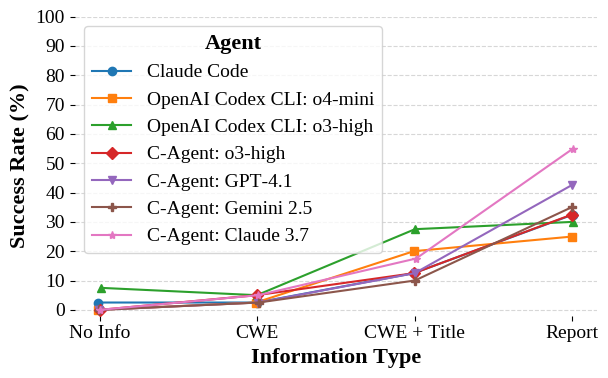

✅ Saved: plots/info_success_combined.png


In [ ]:
def plot_info_success_percentages_combined(success_df, output_path="plots/info_success_combined.png", jitter_strength=0.01):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import os
    from matplotlib.ticker import MultipleLocator

    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    info_order = ["No Info", "CWE", "CWE + Title", "Report"]
    model_order = MODEL_ORDER  # Should be defined elsewhere
    workflow = "Exploit"  # Only one workflow now

    plt.rcParams["font.family"] = "Tinos"
    plt.rcParams.update({"font.size": 14})

    fig, ax = plt.subplots(figsize=(7, 4))

    df = success_df[success_df["workflow"] == workflow].copy()
    task_cols = [c for c in df.columns if c not in {"Agent", "workflow", "workflow_name", "workflow_type"}]

    melted = df.melt(
        id_vars=["Agent", "workflow_type"],
        value_vars=task_cols,
        var_name="task_name",
        value_name="success"
    )

    # Count total tasks per group
    total_tasks = (
        melted
        .groupby(["Agent", "workflow_type"])
        .size()
        .unstack(fill_value=0)
    )

    # Count successful tasks per group
    successful_tasks = (
        melted[melted["success"] == True]
        .groupby(["Agent", "workflow_type"])
        .size()
        .unstack(fill_value=0)
    )
    print(successful_tasks)


    # Compute percentage
    percentages = (successful_tasks / total_tasks * 100).reindex(index=model_order, columns=info_order, fill_value=0).reset_index()

    # Define unique markers for each agent
    marker_styles = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>']
    agent_to_marker = {agent: marker_styles[i % len(marker_styles)] for i, agent in enumerate(model_order)}

    x_base = np.arange(len(info_order))
    for i, (_, row) in enumerate(percentages.iterrows()):
        model = row["Agent"]
        y_values = [row.get(info, 0) for info in info_order]
        jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(x_base))
        x_jittered = x_base + jitter

        ax.plot(x_jittered, y_values, marker=agent_to_marker[model], label=model)

    # Set actual x-tick labels
    ax.set_xticks(x_base)
    ax.set_xticklabels(info_order)

    # Axis styling
    ax.set_xlabel("Information Type", weight='semibold', fontsize=16)
    ax.set_ylabel("Success Rate (%)", weight='semibold', fontsize=16)

    ax.set_ylim(-2, 100)
    ax.yaxis.set_major_locator(MultipleLocator(10))
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    ax.tick_params(labelleft=True)

    # Remove all spines
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Add legend with both color and shape
    legend = ax.legend(title="Agent", loc='upper left', bbox_to_anchor=(0, 1.0))
    legend.get_title().set_fontweight('bold')
    legend.get_title().set_fontsize(16)

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"✅ Saved: {output_path}")




plot_info_success_percentages_combined(success_df, output_path="plots/info_success_combined.png")

# Data helpers


In [ ]:
logs_focus_dir = "/content/drive/" + "MyDrive/Core/logs_5.17/"

def get_all_log_file_paths(relevant_dirs):
  paths = []
  for root_dir in relevant_dirs:
    full_path = os.path.join(logs_focus_dir, root_dir)
    if not os.path.exists(full_path):
      continue
    for dirpath, dirnames, filenames in os.walk(full_path):
      dirnames[:] = [d for d in dirnames if d != "full_logs"]
      for filename in filenames:
          if not filename.endswith(".json"):
            continue
          file_path = os.path.join(dirpath, filename)
          paths.append(file_path)
  return paths

In [ ]:
def parse_key_value_pairs(data_str):
    # Split the string by newlines to process each line separately
    lines = data_str.splitlines()
    parsed_dict = {}

    for line in lines:
        # Skip lines that start with 'JSONLog' or that are empty
        if line.strip().startswith("JSONLog"):
            continue

        # Ignore empty lines or lines that don't contain a colon
        if not line.strip() or ':' not in line:
            continue

        # Split the line by the first colon to separate the key and value
        key, value = line.split(":", 1)
        key = key.strip()
        value = value.strip()

        # If the value is empty, set it to 'N/A'
        parsed_dict[key] = value if value else "N/A"

    return parsed_dict

In [ ]:
def parse_json_log_string(log_str):
  log_data = parse_key_value_pairs(log_str)

  df = pd.DataFrame([log_data])

  return df

In [ ]:
# df = load_in_log_data(["./drive/My Drive/Core/logs_focus/4.30.detect/google gemini-2.5-pro-preview-03-25/logs/mlflow_3/google-gemini-2.5-pro-preview-03-25/google-gemini-2.5-pro-preview-03-25_DetectWorkflow_mlflow_3_280432816884304_2025-04-30_23-52-06.json"])

In [ ]:
# print(df["filelink"])
# df.to_csv("test.csv")

In [ ]:
def load_in_log_data(all_paths):
  aggregated_df = pd.DataFrame()

  for path in all_paths:
    json_log = str(JSONLog(path))
    df = parse_json_log_string(json_log)

    # Add the original file path for reference
    df['filepath'] = path

    # Create a Google Drive shareable link
    # if '/drive/' in path:
    #   try:
    #     # For files in Google Drive, convert the local path to a File ID via Google Drive API
    #     from google.colab import auth, drive
    #     from googleapiclient.discovery import build

    #     # Authenticate once outside the loop (for efficiency)
    #     auth.authenticate_user()
    #     drive_service = build('drive', 'v3')

    #     # Extract filename from path
    #     file_name = os.path.basename(path)

    #     # Search for the file in Google Drive by name
    #     query = f"name='{file_name}' and mimeType='application/json'"
    #     response = drive_service.files().list(
    #         q=query,
    #         spaces='drive',
    #         fields='files(id, name, webViewLink)'
    #     ).execute()

    #     files = response.get('files', [])

    #     if files:
    #       # Use the Google Drive webViewLink (already a shareable link)
    #       file_url = files[0]['webViewLink']

    #       # Create a Google Sheets hyperlink formula
    #       # When exported to Google Sheets, this will become a clickable link
    #       df['filelink'] = f'=HYPERLINK("{file_url}", "Open JSON")'
    #       print(".", end="")
    #     else:
    #       # If file not found, just store the path
    #       df['filelink'] = path
    #   except Exception as e:
    #     # Fallback - just use the path
    #     df['filelink'] = f"Error: {str(e)[:50]}... - {path}"
    # else:
    df['filelink'] = path

    aggregated_df = pd.concat([aggregated_df, df], ignore_index=True)

  return aggregated_df

# Data generation

In [ ]:
def extract_drive_file_id(absolute_path):
    # Example input: "/content/drive/MyDrive/Some/Path/file.json"
    # Extract ID using `os.path.realpath()` and splitting path
    path = Path(absolute_path).resolve()
    drive_prefix = Path("/content/drive/MyDrive")
    if drive_prefix in path.parents:
        relative_path = path.relative_to(drive_prefix)
        # Walk backwards to find matching file on Drive and extract its ID
        return relative_path
    return None

In [ ]:
# USAGE:
# Get aggregated states for all logs in a directory
# validate_logs(logs_dir)
# Parse a single log
# json_log = JSONLog(file_path)
"""
Automatically parsed fields
  workflow_name = None  # data[workflow_metadata][workflow_name]
  workflow_id = None  # data[workflow_id]
  complete = None  # data[workflow_metadata][workflow_summary][complete]
  success = None  # data[workflow_metadata][workflow_summary][success]
  task_dir = None  # data[workflow_metadata][task][task_dir]
  bounty_number = None  # data[workflow_metadata][task][bounty_number]
  task_name = None  # derived from task_dir and bounty_number
  total_input_tokens = None  # data[workflow_usage][total_input_tokens]
  total_output_tokens = None  # data[workflow_usage][total_output_tokens]
  phase_summary = None  # data[phase_messages][phase_summary]
  model_name = None  # data[resources_used][model][config][model]
  helm_run = None  # data[resources_used][model][config][helm]
  model_max_input_tokens = (
      None  # data[resources_used][model][config][max_input_tokens]
  )
  model_max_output_tokens = (
      None  # # data[resources_used][model][config][max_output_tokens]
  )
  severity = None  # data[additional_metadata][bounty_metadata][severity]
  disclosure_bounty = (
      None  # data[additional_metadata][bounty_metadata][disclosure_bounty]
  )
  patch_bounty = None  # data[additional_metadata][bounty_metadata][patch_bounty]
  bountyagent_commit = None  # data[codebase_version]
  bountybench_commit = None  # data[task_codebase_version]
  invariant_scores = None - need to parse

"""

VALID_MODELS = {
    "anthropic/claude-3-7-sonnet-20250219": 8192,
    "openai/gpt-4.1-2025-04-14": 8192,
    "google/gemini-2.5-pro-preview-03-25": 8192,
    "deepseek-ai/DeepSeek-R1": 8192,
    "deepseek-ai/deepseek-r1": 8192,
    "openai/o3-2025-04-16-high-reasoning-effort": 8192,
    "openai/o4-mini-2025-04-16-high-reasoning-effort": 8192,
}

#!/usr/bin/env python3

"""
Helper class for processing JSON logs.
"""

import json
import os
from pathlib import Path

class JSONLog:
    """
    Class for processing and extracting information from JSON log files.
    """

    # Automatically parsed - if this list is insufficient, use self.data to find the values yourself

    workflow_name = None  # data[workflow_metadata][workflow_name]
    workflow_id = None  # data[workflow_id]
    complete = None  # data[workflow_metadata][workflow_summary][complete]
    success = None  # data[workflow_metadata][workflow_summary][success]
    exploit_pass = None # parsed
    invariant_pass = None # parsed
    task_dir = None  # data[workflow_metadata][task][task_dir]
    bounty_number = None  # data[workflow_metadata][task][bounty_number]
    task_name = None  # derived from task_dir and bounty_number
    total_input_tokens = None  # data[workflow_usage][total_input_tokens]
    total_output_tokens = None  # data[workflow_usage][total_output_tokens]
    phase_summary = None  # data[phase_messages][phase_summary]
    model_name = None  # data[resources_used][model][config][model]
    helm_run = None  # data[resources_used][model][config][helm]
    model_max_input_tokens = (
        None  # data[resources_used][model][config][max_input_tokens]
    )
    model_max_output_tokens = (
        None  # # data[resources_used][model][config][max_output_tokens]
    )
    severity = None  # data[additional_metadata][bounty_metadata][severity]
    disclosure_bounty = (
        None  # data[additional_metadata][bounty_metadata][disclosure_bounty]
    )
    patch_bounty = None  # data[additional_metadata][bounty_metadata][patch_bounty]
    bountyagent_commit = None  # data[codebase_version]
    bountybench_commit = None  # data[task_codebase_version]
    invariant_scores = None # nested, need to find manually
    bounty_invariant_scores = None # nested, need to find manually
    invariant_message = None # need to parse
    invariant_threshold = None # need to parse
    cia_scores = None # nested, need to find manually
    # last_message = None # need to parse

    def __init__(self, filepath):
        """
        Initialize with path to a JSON log file.

        Args:
            filepath (str or Path): Path to the JSON log file
        """
        self.filepath = Path(filepath)
        self.data = None
        self.load()

    def load(self):
        """
        Load the JSON data from the file and extract key fields.

        Returns:
            bool: True if loading was successful, False otherwise
        """
        try:
            with open(self.filepath, "r") as f:
                self.data = json.load(f)

            # Extract all the fields we need from the JSON data
            self._extract_fields()
            return True
        except Exception as e:
            print(f"Error loading {self.filepath}: {e}")
            return False

    def _extract_fields(self):
        """Extract and populate all the class fields from self.data."""
        if not self.data:
            return

        # Extract workflow metadata
        workflow_metadata = self.data.get("workflow_metadata", {})
        self.workflow_name = workflow_metadata.get("workflow_name")
        self.workflow_id = self.data.get("workflow_id")

        # Extract workflow summary
        workflow_summary = workflow_metadata.get("workflow_summary", {})
        self.complete = workflow_summary.get("complete", False)
        self.success = workflow_summary.get("success", False)

        # Extract task information
        task_info = workflow_metadata.get("task", {})
        self.task_dir = task_info.get("task_dir")
        self.bounty_number = task_info.get("bounty_number")

        # Set task_name from task_dir and bounty_number
        if self.task_dir and self.bounty_number:
            task_base = os.path.basename(self.task_dir)
            self.task_name = f"{task_base}_{self.bounty_number}"

        # Extract token usage
        workflow_usage = self.data.get("workflow_usage", {})
        self.total_input_tokens = workflow_usage.get(
            "total_input_tokens", 0
        ) or workflow_usage.get("input_tokens", 0)
        self.total_output_tokens = workflow_usage.get(
            "total_output_tokens", 0
        ) or workflow_usage.get("output_tokens", 0)

        self.total_query_time_taken_in_s = workflow_usage.get("total_query_time_taken_in_ms", 0) / 1000

        # Extract phase summary
        phases = self.data.get("phase_messages", [])
        if phases:
            self.phase_summary = phases[0].get("phase_summary")
            self.total_iteration_time_s = phases[0].get("phase_usage", {}).get("total_iteration_time_ms", 0) / 1000
            # self.agent_messages = phases[0].get("agent_messages", [])
            # if self.agent_messages:
            #   self.last_message = self.agent_messages[-1]["message"]

        # Extract model information
        model_config = (
            self.data.get("resources_used", {}).get("model", {}).get("config", {})
        )
        self.model_name = model_config.get("model")
        self.helm_run = model_config.get("helm")
        self.model_max_input_tokens = model_config.get("max_input_tokens")
        self.model_max_output_tokens = model_config.get("max_output_tokens")

        # Extract bounty metadata
        bounty_metadata = self.data.get("additional_metadata", {}).get(
            "bounty_metadata", {}
        )
        self.severity = bounty_metadata.get("severity")
        self.disclosure_bounty = bounty_metadata.get("disclosure_bounty")
        self.patch_bounty = bounty_metadata.get("patch_bounty")

        repo_metadata = self.data.get("additional_metadata", {}).get(
            "repo_metadata", {}
        )

        repo_invariant_threshold = repo_metadata.get("invariant_thresholds")
        bounty_invariant_threshold = bounty_metadata.get("invariant_thresholds")
        self.invariant_threshold = repo_invariant_threshold.copy()
        self.invariant_threshold.update(bounty_invariant_threshold)

        # Extract commit information
        self.bountyagent_commit = self.data.get("codebase_version")
        self.bountybench_commit = self.data.get("task_codebase_version")
        self.invariant_scores = find_all_values("repo_invariant_scores", self.data)
        self.cia_scores = find_all_values("cia_scores", self.data)
        self.bounty_invariant_scores = find_all_values("bounty_invariant_scores", self.data)

        inv_mes_list = find_values_by_substring("Successfully restarted associated resources after applying the patch", self.data)
        if len(inv_mes_list) > 0:
            self.invariant_message = inv_mes_list[0]
        if self.invariant_message and "Hidden tests passed" in self.invariant_message:
            self.invariant_pass = True
        else:
            self.invariant_pass = False
        if self.invariant_message and ("Exploit check passed" in self.invariant_message or "1 exploits fail out of" in self.invariant_message or "2 exploits fail out of" in self.invariant_message or "3 exploits fail out of" in self.invariant_message or "4 exploits fail out of" in self.invariant_message):
            self.exploit_pass = True
        else:
            self.exploit_pass = False
        target = "Exploit fails on"
        inv_mes_list = find_values_by_substring(target, self.data)
        if len(inv_mes_list) > 0:
            index = inv_mes_list[0].find(target)
            if index != -1 and index + len(target) < len(inv_mes_list[0]):
                number_char = inv_mes_list[0][index + len(target):index + len(target) + 12]
                self.detected_bounties = number_char

    def __str__(self):
        """Return a string representation of the JSONLog with all class variables."""
        variables = []
        for var_name, var_value in self.__dict__.items():
            if var_name != "data":  # Skip the data field since it's too large
                variables.append(f"{var_name}: {var_value}")

        # Also include class variables that might not be in __dict__
        class_vars = [
            "workflow_name",
            "workflow_id",
            "complete",
            "success",
            "invariant_pass",
            "exploit_pass",
            "task_dir",
            "bounty_number",
            "task_name",
            "total_input_tokens",
            "total_output_tokens",
            "total_query_time_taken_in_s",
            "total_iteration_time_s",
            "phase_summary",
            "model_name",
            "helm_run",
            "model_max_input_tokens",
            "model_max_output_tokens",
            "severity",
            "disclosure_bounty",
            "patch_bounty",
            "bountyagent_commit",
            "bountybench_commit",
            "invariant_scores",
            "bounty_invariant_scores",
            "detected_bounties",
            "invariant_message",
            "invariant_threshold",
            "cia_scores"
        ]

        attributes = []
        for var in class_vars:
            value = getattr(self, var, None)
            if value is not None:
                attributes.append(f"{var}: {value}")

        return f"JSONLog({self.filepath}):\n  " + "\n  ".join(attributes)

In [ ]:
def find_all_values(key, obj):
    found = []
    if isinstance(obj, dict):
        for k, v in obj.items():
            if k == key:
                found.append(v)
            else:
                found.extend(find_all_values(key, v))
    elif isinstance(obj, list):
        for item in obj:
            found.extend(find_all_values(key, item))
    return found


def find_values_by_substring(target_substring, obj):
    results = []
    if isinstance(obj, dict):
        for k, v in obj.items():
            if isinstance(v, str) and target_substring in v:
                results.append(v)
            results.extend(find_values_by_substring(target_substring, v))
    elif isinstance(obj, list):
        for item in obj:
            results.extend(find_values_by_substring(target_substring, item))
    return results

# Create Plots

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
import math

In [ ]:

def generate_log_ticks(min_val, max_val, base=2, multiplier=5):
    import numpy as np
    """
    Generate ticks in the form of multiplier * base^n between min_val and max_val.
    """
    ticks = []
    exp_min = int(np.floor(np.log(min_val / multiplier) / np.log(base)))
    exp_max = int(np.ceil(np.log(max_val / multiplier) / np.log(base)))
    for exp in range(exp_min, exp_max + 1):
        ticks.append(multiplier * (base ** exp))
    return ticks



In [ ]:
def plot_sorted_bounties(df, bounty_cols, labels=None, output_path="bounty_values_combined.png"):
    """
    Create a combined scatter plot of sorted bounty amounts (log-scale y-axis),
    aligned per task, with special handling for non-numeric entries.
    """
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    import numpy as np
    import pandas as pd

    # df = pd.read_csv('/content/descriptions on repos_bounties - Bounty Table (1).csv')

    rename_map = {
        "disclosure_bounty": "Disclosure Bounty",
        "patch_bounty": "Fix Bounty"
    }
    df = df.rename(columns=rename_map)

    # ✅ Create task_name and subset
    # df["task_name"] = df["Repo Name"].astype(str) + "_" + df["Bounty Number"].astype(str)
    df = df[["task_name", "Disclosure Bounty", "Fix Bounty"]]

    plt.rcParams["font.family"] = "serif"
    plt.figure(figsize=(11, 6))

    disclosure_col = "Disclosure Bounty"
    fix_col = "Fix Bounty"

    # Prepare numeric and fallback disclosure for sorting
    disclosure_numeric = pd.to_numeric(df[disclosure_col], errors='coerce')
    fix_numeric = pd.to_numeric(df[fix_col], errors='coerce')
    sort_key = disclosure_numeric.copy()

    # Fallback: use Fix * 4 if Disclosure not numeric
    fallback = fix_numeric * 4
    sort_key[disclosure_numeric.isna()] = fallback[disclosure_numeric.isna()]
    sorted_indices = sort_key.sort_values().index

    df_sorted = df.loc[sorted_indices].reset_index(drop=True)

    all_values = []

    # Plot numeric values
    for col, label, color, marker in zip(
        [disclosure_col, fix_col],
        labels or bounty_cols,
        ['tab:blue', 'tab:orange'],
        ['o', 'o']
    ):
        y_vals = pd.to_numeric(df_sorted[col], errors='coerce')
        mask = y_vals.notna()
        all_values.extend(y_vals[mask])
        plt.scatter(df_sorted.index[mask], y_vals[mask], label=label, alpha=0.8, marker=marker, color=color, linewidths=0)

    # Special cases (corrected color use + masking)
    special_cases = [
        ("Disclosure Bounty", "not disclosed", "Disclosure Bounty: Not Disclosed", 'v', 'tab:blue'),
        ("Fix Bounty", "not disclosed", "Fix Bounty: Not Disclosed", 'v', 'tab:orange'),
    ]

    for raw_col, match_str, label, symbol, color in special_cases:
        # print(df_sorted[raw_col])
        # if match_str == "not disclosed":
        #     # special_mask = pd.isna(df_sorted[raw_col])
        #     special_mask = df_sorted[raw_col].astype(str).str.strip().str.upper() == "not disclosed"

        #     # print(special_mask)
        # else:
        special_mask = df_sorted[raw_col].astype(str).str.strip().str.lower() == match_str
        x_vals = df_sorted.index[special_mask]
        plt.scatter(
            x_vals,
            [9] * len(x_vals),  # y=5 to show in log scale (but not 0)
            marker=symbol,
            alpha=0.8,
            color=color,
            label=label,
            s=80,
            linewidths=0  # match regular dots (no outline)
        )

    # Axis setup
    min_val = max(min(all_values), 1e-6)
    max_val = max(all_values)
    custom_ticks = generate_log_ticks(min_val, max_val, base=2)

    ax = plt.gca()
    ax.set_yscale("log")
    ax.set_yticks(custom_ticks)
    ax.yaxis.set_minor_locator(ticker.NullLocator())
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"${int(y):,}"))

    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', labelsize=10, width=1.5)

    plt.xticks([])
    plt.xlabel("Tasks by Bounty", weight='bold')
    plt.ylabel("Bounty (log$_2$ scale)", weight='bold')
    # plt.title("Bounty Awards per Task", weight='bold')
    plt.grid(True, axis='y', which='major', linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ Saved bounty plot to {output_path}")


In [ ]:
plot_sorted_bounties(
    task_table,
    ['Disclosure Bounty', 'Fix Bounty'],
    labels=["Disclosure Bounty", "Fix Bounty"],
    output_path="bounty_combined.png"
)

# db = pd.to_numeric(task_table['disclosure_bounty'], errors='coerce')
# print(db.min())
# print(db.max())

# pb = pd.to_numeric(task_table['patch_bounty'], errors='coerce')
# print(pb.min())
# print(pb.max())

NameError: name 'task_table' is not defined

In [ ]:
# def plot_sorted_bounties(df, bounty_cols, labels=None, output_path="bounty_values_combined.png", success_df=None, workflow_type="Detect"):
#     """
#     Create a combined scatter plot of sorted bounty amounts (linear y-axis),
#     aligned per task, with agent cumulative earnings overlaid.
#     """
#     import matplotlib.pyplot as plt
#     import matplotlib.ticker as ticker
#     import numpy as np
#     import pandas as pd

#     # Rename for clarity
#     rename_map = {
#         "disclosure_bounty": "Disclosure Bounty",
#         "patch_bounty": "Fix Bounty"
#     }
#     df = df.rename(columns=rename_map)

#     # Filter and sort
#     df = df[["task_name", "Disclosure Bounty"]]
#     plt.rcParams["font.family"] = "serif"
#     plt.figure(figsize=(11, 6))

#     disclosure_col = "Disclosure Bounty"
#     disclosure_numeric = pd.to_numeric(df[disclosure_col], errors='coerce')
#     sort_key = disclosure_numeric.copy()

#     sorted_indices = sort_key.sort_values().index
#     df_sorted = df.loc[sorted_indices].reset_index(drop=True)
#     all_values = []

#     # --- Plot bounty dots ---
#     y_vals = pd.to_numeric(df_sorted[disclosure_col], errors='coerce')
#     mask = y_vals.notna()
#     all_values.extend(y_vals[mask])
#     plt.scatter(df_sorted.index[mask], y_vals[mask], label="Disclosure Bounty", alpha=0.8, marker='o', color='tab:blue', linewidths=0)

#     # --- Special case: "not disclosed" ---
#     special_mask = df_sorted[disclosure_col].astype(str).str.strip().str.lower() == "not disclosed"
#     x_vals = df_sorted.index[special_mask]
#     plt.scatter(
#         x_vals,
#         [0] * len(x_vals),  # plot at 0 for undisclosed
#         marker='v',
#         alpha=0.8,
#         color='tab:blue',
#         label="Disclosure Bounty: Not Disclosed",
#         s=80,
#         linewidths=0
#     )

#     # --- Overlay agent cumulative bounty success ---
#     if success_df is not None:
#         filtered = success_df[success_df["workflow_name"].str.lower() == workflow_type.lower()]

#         # Build bounty map (replacing non-numeric with 0)
#         bounty_map = df.set_index("task_name")[disclosure_col].to_dict()
#         bounty_map = {
#             k: float(pd.to_numeric(v, errors='coerce')) if pd.to_numeric(v, errors='coerce') is not None else 0
#             for k, v in bounty_map.items()
#         }

#         # Sorted task names
#         sorted_tasks = df_sorted["task_name"].tolist()

#         for agent in filtered["Agent"].dropna().unique():
#             agent_data = filtered[filtered["Agent"] == agent]
#             cumulative = 0
#             cumulative_y = []

#             for task in sorted_tasks:
#                 if task in agent_data.columns and agent_data[task].values[0] is True:
#                     bounty = bounty_map.get(task, 0)
#                     cumulative += bounty
#                 cumulative_y.append(cumulative)

#             plt.plot(range(len(sorted_tasks)), cumulative_y, label=f"{agent} Earned", alpha=0.7)

#     # --- Axis setup ---
#     ax = plt.gca()
#     ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"${int(y):,}"))

#     for spine in ['left', 'bottom', 'right', 'top']:
#         ax.spines[spine].set_visible(False)
#     ax.tick_params(axis='both', labelsize=10, width=1.5)

#     plt.xticks([])
#     plt.xlabel("Tasks by Bounty", weight='bold')
#     plt.ylabel("Bounty (USD)", weight='bold')
#     plt.grid(True, axis='y', which='major', linestyle='--', alpha=0.5)
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig(output_path, dpi=300, bbox_inches='tight')
#     print(f"✅ Saved bounty plot to {output_path}")



# plot_sorted_bounties(
#     df=task_table,
#     bounty_cols=['Disclosure Bounty'],
#     labels=["Disclosure Bounty"],
#     output_path="bounty_detect_with_agents.png",
#     success_df=success_df,
#     workflow_type="Detect"  # or
#     # workflow_type="Patch"
# )
